## SVM Report Version 3*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,cross_val_score)
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# this will hide warnings in jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# read in the .xlsx using 'openpyxl' engine
# use the column 'app_id' as the index
df = pd.read_excel("MAXD_UTD_MODELDEVELOPMENT_DATA.xlsx", index_col='app_id', engine='openpyxl')

#  dropping duplicates m_bba_p_A05, m_bba_p_A06, m_bba_p_B38 
df = df.drop(columns=["m_bba_p_A05","m_bba_p_A06","m_bba_p_B38"], axis=1)

In [2]:
# Count plot utility function
def count_plot(series, x0 ="", x1 ="", title=""):
    graph = sns.countplot(series)
    graph.set_title(title)
    graph.set_xticklabels([x0, x1])
    plt.show()
    counter = Counter(series)
    print(counter)
    goods, bads = counter[0], counter[1]
    print(f"% good customers: {goods / len(series) * 100:.2f}%")
    print(f"% bad customers: {bads / len(series) * 100:.2f}%")

# utility function for constructing confusion matrix visualization
# 'Good' ~ good candidate (not bad)
# 'Bad' ~ bad candidate (is bad)
def visualize_conf_mat(cfmat):
    # plot confusion matrix
    plt.rcParams["figure.figsize"] = [6.00,4.00]
    counts = [f"{v}" for v in cfmat.flatten()]
    names = ["True Good","False Bad","False Good","True Bad"]
    labels = np.asarray([f"{n}\n\n{c}" for c,n in zip(counts,names)]).reshape(2,2)
    ax = sns.heatmap(cfmat,
                fmt='',
                annot=labels, 
                cmap="vlag_r")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")
    ax.xaxis.set_ticklabels(["Good","Bad"])
    ax.yaxis.set_ticklabels(["Good","Bad"])
    plt.show()
    
# imports for report function
def report(classifier, X_train, X_test, y_train, y_test, train=True, title=''):
    if title:
        print(f"{title} Report\n\n")
    if train:
        y_pred = classifier.predict(X_train)
        clsf_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True))
        print("Train Result:\n"+"="*30)
        print("-"*30)
        print(f"Classification Report:\n{clsf_report}")
        print("AUC: %.2f" % roc_auc_score(y_train, y_pred))
        print("-"*30)
        visualize_conf_mat(confusion_matrix(y_train,y_pred))
        print(f"Accuracy Score: {accuracy_score(y_train, y_pred)*100:.2f}%\n\n")
        return y_pred
    else:
        y_pred = classifier.predict(X_test)
        clsf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
        print("Test Result:\n"+"="*30)
        print("-"*30)
        print(f"Classification Report:\n{clsf_report}")
        print("AUC: %.2f" % roc_auc_score(y_test, y_pred))
        print("-"*30)
        visualize_conf_mat(confusion_matrix(y_test,y_pred))
        print(f"Accuracy Score: {accuracy_score(y_test, y_pred)*100:.2f}%\n\n")
        return y_pred

def plot_roc(y_test, y_pred, title="", legend=""):
    RocCurveDisplay.from_predictions(y_test, y_pred, name=legend)
    plt.title(title)
    plt.show()

<br><br>

In [3]:
df.head(5)

,bad,m_inq_date_of_last_activity,m_CCRS_ALL_dd_7_years_ago,m_ccr_days_since_last_ontime_pmt,m_ccr_days_since_last_loan_pmt,m_inq_net_monthly_income,m_bba_p_d_since_validated_trade,m_bba_p_default_history,m_cbb_A05,m_cbb_A06,...,m_ccrea_bcx7110,m_ccrea_brc7140,m_ccrea_brc7160,m_ccrea_iln7150,m_bba_p_account_age_code,m_bba_p_validated_through_trades,m_ccr_worst_payment_rating,m_ccrea_aua6280,m_ccrea_bcc6160,m_ccrea_iln6230
app_id,,,,,,,,,,,,,,,,,,,,,
16269,0,1,0,1,1,0,0.228023,0.262892,1,0,...,-0.080840,0.154884,0.149725,-0.187540,0,1,0,-0.252640,-0.088770,-0.145330
16270,0,1,0,1,1,0,0.088674,-0.225760,1,0,...,-0.088520,-0.129000,0.149725,0.073789,0,1,0,0.058109,0.012685,0.136701
16271,0,0,1,1,1,0,0.228023,-0.225760,1,0,...,-0.080840,-0.211390,-0.325230,0.073789,0,1,0,0.043854,-0.088770,-0.145330
16272,0,0,0,1,1,0,-0.080440,-0.096340,0,1,...,0.182567,0.154884,0.149725,0.073789,1,0,0,0.125723,0.153668,0.136701
16273,0,1,1,0,0,0,0.228023,0.262892,1,0,...,0.182567,0.154884,0.149725,0.073789,0,1,0,0.125723,0.153668,-0.145330


In [4]:
numeric_columns = df.drop("bad",axis=1).select_dtypes('float64').columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns].values)

In [5]:
# separating independent 'X' and dependent 'y' sets,
# where 'X' is all column data that is NOT 'bad'
# and 'y' is the 'bad' column
X = df.drop('bad',axis=1)
y = df['bad']

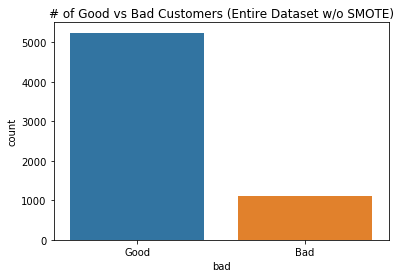

Counter({0: 5240, 1: 1118})
% good customers: 82.42%
% bad customers: 17.58%


In [6]:
# plotting number of good vs bad customer samples in dependent dataset
count_plot(y, x0="Good", x1="Bad", title="# of Good vs Bad Customers (Entire Dataset w/o SMOTE)")

<br>

### using smote

In [7]:
# applying SMOTE technique to balance the dataset between minority ('bad' customer) and majority ('good' customer) classes
smt = SMOTE(random_state=44)
X_resampled, y_resampled = smt.fit_resample(X,y)

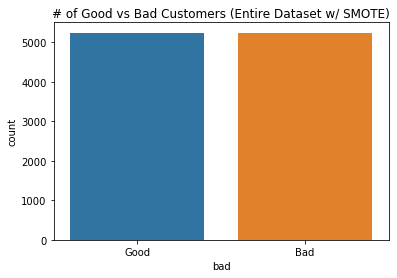

Counter({0: 5240, 1: 5240})
% good customers: 50.00%
% bad customers: 50.00%


In [8]:
# plotting number of good vs bad customer samples in dependent dataset
count_plot(y_resampled, x0="Good", x1="Bad", title="# of Good vs Bad Customers (Entire Dataset w/ SMOTE)")

In [9]:
# calculating VIF initially on the resampled independent variable set
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

def calc_vif(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [VIF(X.values,i) for i in range(X.shape[1])]
    return vif
            

vif_df = calc_vif(X_resampled)

In [10]:
# finding features in X with VIF >= 10
vif_thresh10 = vif_df[vif_df["VIF"] >= 10]
print(f"# of features w/ VIF >= 10: {len(vif_thresh10)}")
print(f"# of features remaining after removal: {len(df.drop('bad',axis=1).columns)-len(vif_thresh10)}")
vif_thresh10

# of features w/ VIF >= 10: 199
# of features remaining after removal: 84


,Features,VIF
1,m_CCRS_ALL_dd_7_years_ago,11.839984
2,m_ccr_days_since_last_ontime_pmt,10.350300
3,m_ccr_days_since_last_loan_pmt,12.165296
7,m_cbb_A05,34.698232
8,m_cbb_A06,10.596156
...,...,...
257,m_caaea_rev5627,747.293264
261,m_caaea_tbca2619,inf
267,m_ccrea_tbca2624,inf
270,m_ccrea_tbcc3203,16.852494


In [11]:
# finding features in X with VIF >= 8
vif_thresh8 = vif_df[vif_df["VIF"] >= 8]
print(f"# of features w/ VIF >= 8: {len(vif_thresh8)}")
print(f"# of features remaining after removal: {len(df.drop('bad',axis=1).columns)-len(vif_thresh8)}")
vif_thresh8

# of features w/ VIF >= 8: 208
# of features remaining after removal: 75


,Features,VIF
1,m_CCRS_ALL_dd_7_years_ago,11.839984
2,m_ccr_days_since_last_ontime_pmt,10.350300
3,m_ccr_days_since_last_loan_pmt,12.165296
7,m_cbb_A05,34.698232
8,m_cbb_A06,10.596156
...,...,...
257,m_caaea_rev5627,747.293264
261,m_caaea_tbca2619,inf
267,m_ccrea_tbca2624,inf
270,m_ccrea_tbcc3203,16.852494


In [12]:
y_resampled

0        0
1        0
2        0
3        0
4        0
        ..
10475    1
10476    1
10477    1
10478    1
10479    1
Name: bad, Length: 10480, dtype: int64

<br>

### Train Test Split

In [13]:
# adjusting the resampled dataset (w/o class imbalance) with the new selections of high collinear features removed,
# and making two sets: (X8,y8) and (X10,y10) where Xj is a dataframe with features removed that have VIF >= j for threshold j
# and yj are the dependent datasets corresponding to those that are removed.

# X8,y8
X8 = X_resampled.drop(columns=vif_thresh8.Features, axis=1)
y8 = y_resampled
# X10,y10
X10 = X_resampled.drop(columns=vif_thresh10.Features, axis=1)
y10 = y_resampled

# partition the data into 30% test, 70% train subsets across X & y
X8_train, X8_test, y8_train, y8_test = train_test_split(X8.values,y8,test_size=0.3,random_state=10)

# partition the data into 30% test, 70% train subsets across X & y
X10_train, X10_test, y10_train, y10_test = train_test_split(X10.values,y10,test_size=0.3,random_state=5)

### 5-Fold Cross Validation

In [14]:
# computing 5-fold cross validation for linear, poly, and rbf, on the testing proportion of the (X8,y8) & (X10,y10) datasets

# prints out report of cross validation for both VIF >= 8 & VIF >= 10 removed w/different kernels
def show_cv(resultX10, resultX8):
    print(f"Average accuracy of model with 5-fold cross validation w/o VIF >= 10: {resultX10.mean() * 100: .2f}%")
    print(f"scores: {resultX10}\n")
    print(f"Average accuracy of model with 5-fold cross validation w/o VIF >= 8: {resultX8.mean() * 100: .2f}%")
    print(f"scores: {resultX8}\n")


# 5-fold cross validation scores on linear kernel according to accuracy
print("linear kernel")
X10_5fold = cross_val_score(LinearSVC(max_iter=10000), X10_test, y10_test, scoring="accuracy", cv=5)
X8_5fold = cross_val_score(LinearSVC(max_iter=10000), X8_test, y8_test, scoring="accuracy", cv=5)
show_cv(X10_5fold, X8_5fold)

# 5-fold cross validation scores on poly kernel
print("poly kernel")
X10_5fold = cross_val_score(SVC(max_iter=10000,kernel='poly', degree=2, gamma='auto', coef0=1, C=5),
                            X10_test, y10_test, scoring="accuracy", cv=5)

X8_5fold = cross_val_score(SVC(max_iter=10000,kernel='poly', degree=2, gamma='auto', coef0=1, C=5), 
                           X8_test, y8_test, scoring="accuracy", cv=5)
show_cv(X10_5fold, X8_5fold)

# 5-fold cross validation scores on rbf kernel
print("rbf kernel")
X10_5fold = cross_val_score(SVC(max_iter=10000,kernel='rbf', gamma=0.5, C=1), 
                            X10_test, y10_test, scoring="accuracy", cv=5)
X8_5fold = cross_val_score(SVC(max_iter=10000,kernel='rbf', gamma=0.5, C=1), 
                           X8_test, y8_test, scoring="accuracy", cv=5)
show_cv(X10_5fold, X8_5fold)

linear kernel
Average accuracy of model with 5-fold cross validation w/o VIF >= 10:  58.08%
scores: [0.64228935 0.54213037 0.61685215 0.55484897 0.5477707 ]

Average accuracy of model with 5-fold cross validation w/o VIF >= 8:  58.40%
scores: [0.53736089 0.57710652 0.58346582 0.6200318  0.60191083]

poly kernel
Average accuracy of model with 5-fold cross validation w/o VIF >= 10:  51.81%
scores: [0.47217806 0.49602544 0.54054054 0.52782194 0.55414013]

Average accuracy of model with 5-fold cross validation w/o VIF >= 8:  48.86%
scores: [0.46263911 0.47535771 0.52623211 0.46422893 0.51433121]

rbf kernel
Average accuracy of model with 5-fold cross validation w/o VIF >= 10:  50.35%
scores: [0.50715421 0.50238474 0.50238474 0.50238474 0.50318471]

Average accuracy of model with 5-fold cross validation w/o VIF >= 8:  51.37%
scores: [0.51192369 0.51510334 0.51192369 0.51669316 0.51273885]



<br>

### Smote Adjusted | Training & Testing - SVM Linear, Polynomial, Radial

<br>

In [15]:
# X8,y8
X8 = X_resampled.drop(columns=vif_thresh8.Features, axis=1)
y8 = y_resampled
# X10,y10
X10 = X_resampled.drop(columns=vif_thresh10.Features, axis=1)
y10 = y_resampled

# partition the data into 30% test, 70% train subsets across X & y
X8_train, X8_test, y8_train, y8_test = train_test_split(X8.values,y8,test_size=0.3,random_state=10)

# partition the data into 30% test, 70% train subsets across X & y
X10_train, X10_test, y10_train, y10_test = train_test_split(X10.values,y10,test_size=0.3,random_state=5)

Linear Kernel | VIF >= 8 Removed Report


Test Result:
------------------------------
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.724858     0.702495   0.71374     0.713676      0.713954
recall        0.711359     0.716243   0.71374     0.713801      0.713740
f1-score      0.718045     0.709302   0.71374     0.713674      0.713782
support    1611.000000  1533.000000   0.71374  3144.000000   3144.000000
AUC: 0.71
------------------------------


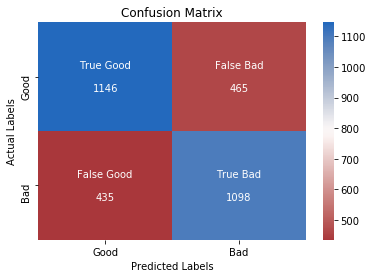

Accuracy Score: 71.37%




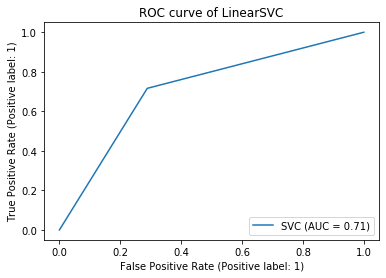

Linear Kernel | VIF >= 10 Removed Report


Test Result:
------------------------------
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.630192     0.817680   0.68416     0.723936      0.723697
recall        0.895305     0.471939   0.68416     0.683622      0.684160
f1-score      0.739712     0.598463   0.68416     0.669088      0.669267
support    1576.000000  1568.000000   0.68416  3144.000000   3144.000000
AUC: 0.68
------------------------------


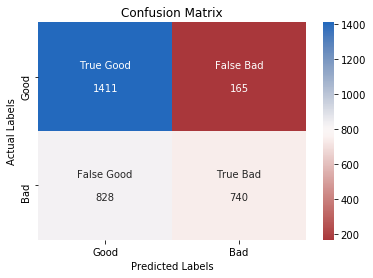

Accuracy Score: 68.42%




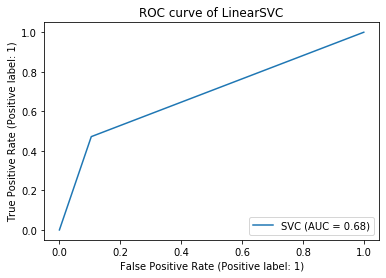

In [16]:
# linear testing report 
# random_state 10 ~ 71% auc/ 71.37% acc
lin_model = LinearSVC(max_iter=10000, random_state=10)
lin_model.fit(X8_train, y8_train)
ypred = report(lin_model, X8_train, X8_test, y8_train, y8_test, train=False,title="Linear Kernel | VIF >= 8 Removed")
plot_roc(y8_test, ypred, title="ROC curve of LinearSVC", legend="SVC")

# linear testing report 
# random_state 110 ~ 68% auc/ 68.42% acc
lin_model2 = LinearSVC(max_iter=10000, random_state=110)
lin_model2.fit(X10_train, y10_train)
ypred = report(lin_model2, X10_train, X10_test, y10_train, y10_test, train=False,title="Linear Kernel | VIF >= 10 Removed")
plot_roc(y10_test, ypred, title="ROC curve of LinearSVC", legend="SVC")

Polynomial Kernel | VIF >=8 Removed Report


Test Result:
------------------------------
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.561111     0.497696  0.508588     0.529403      0.530190
recall        0.188082     0.845401  0.508588     0.516742      0.508588
f1-score      0.281729     0.626541  0.508588     0.454135      0.449858
support    1611.000000  1533.000000  0.508588  3144.000000   3144.000000
AUC: 0.52
------------------------------


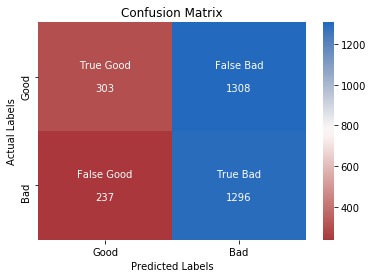

Accuracy Score: 50.86%




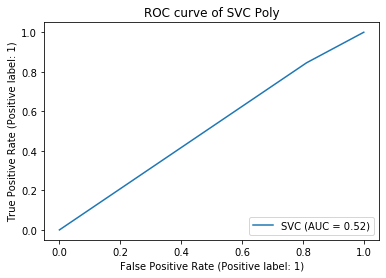

Polynomial Kernel | VIF >=10 Removed Report


Test Result:
------------------------------
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.494662     0.497289  0.496819     0.495975      0.495972
recall        0.176396     0.818878  0.496819     0.497637      0.496819
f1-score      0.260056     0.618795  0.496819     0.439426      0.438969
support    1576.000000  1568.000000  0.496819  3144.000000   3144.000000
AUC: 0.50
------------------------------


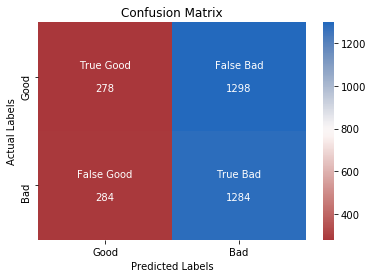

Accuracy Score: 49.68%




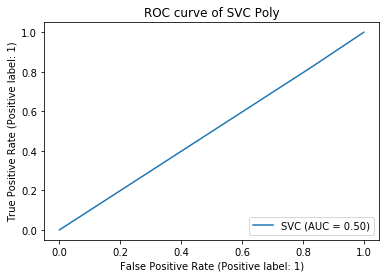

In [17]:
# Polynomial testing report
# random_state 20 ~ 51% auc/ 50.86% acc
poly_model = SVC(max_iter=10000,kernel='poly', degree=2, gamma='auto', coef0=1, C=5, random_state=20)
poly_model.fit(X8_train, y8_train)
ypred = report(poly_model, X8_train, X8_test, y8_train, y8_test, train=False,title="Polynomial Kernel | VIF >=8 Removed")
plot_roc(y8_test, ypred, title="ROC curve of SVC Poly", legend="SVC")

# Polynomial testing report
# random_state 120 ~ 50% auc/ 49.68% acc
poly_model2 = SVC(max_iter=10000,kernel='poly', degree=2, gamma='auto', coef0=1, C=5, random_state=120)
poly_model2.fit(X10_train, y10_train)
ypred = report(poly_model2, X10_train, X10_test, y10_train, y10_test, train=False,title="Polynomial Kernel | VIF >=10 Removed")
plot_roc(y10_test, ypred, title="ROC curve of SVC Poly", legend="SVC")

Radial Basis Function (RBF) Kernel | VIF >=8 Removed Report


Test Result:
------------------------------
Classification Report:
                0            1  accuracy    macro avg  weighted avg
precision     0.0     0.487595  0.487595     0.243798      0.237749
recall        0.0     1.000000  0.487595     0.500000      0.487595
f1-score      0.0     0.655548  0.487595     0.327774      0.319642
support    1611.0  1533.000000  0.487595  3144.000000   3144.000000
AUC: 0.50
------------------------------


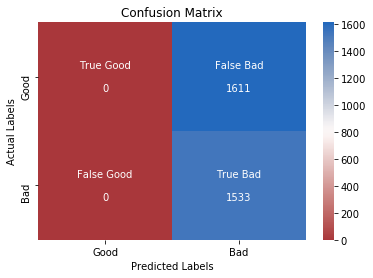

Accuracy Score: 48.76%




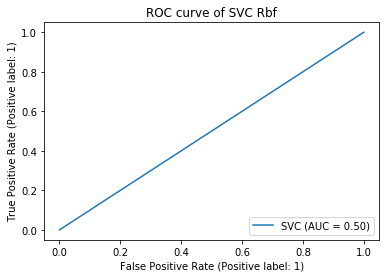

Radial Basis Function (RBF) Kernel | VIF >=10 Removed Report


Test Result:
------------------------------
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.505939     1.000000  0.510496     0.752970      0.752341
recall        1.000000     0.018495  0.510496     0.509247      0.510496
f1-score      0.671925     0.036318  0.510496     0.354122      0.354930
support    1576.000000  1568.000000  0.510496  3144.000000   3144.000000
AUC: 0.51
------------------------------


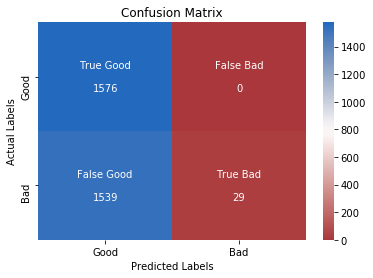

Accuracy Score: 51.05%




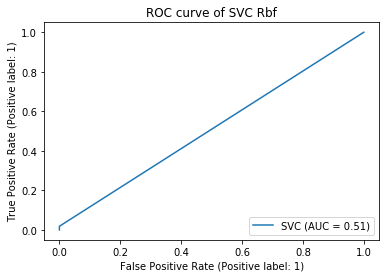

In [18]:
# Rbf testing report
# random_state 30 ~ 50% auc/ 48.76% acc
rbf_model = SVC(max_iter=10000,kernel='rbf', gamma=0.5, C=1, random_state=30)
rbf_model.fit(X8_train, y8_train)
ypred = report(rbf_model, X8_train, X8_test, y8_train, y8_test, train=False,title="Radial Basis Function (RBF) Kernel | VIF >=8 Removed")
plot_roc(y8_test, ypred, title="ROC curve of SVC Rbf", legend="SVC")

# Rbf testing report
# random_state 130 ~ 51% auc/ 51.05% acc
rbf_model2 = SVC(max_iter=10000,kernel='rbf', gamma=0.5, C=1, random_state=130)
rbf_model2.fit(X10_train, y10_train)
ypred = report(rbf_model2, X10_train, X10_test, y10_train, y10_test, train=False,title="Radial Basis Function (RBF) Kernel | VIF >=10 Removed")
plot_roc(y10_test, ypred, title="ROC curve of SVC Rbf", legend="SVC")

<br>

### Recap

<br>
<div class="recap" style="font-size: 20px;">
    <ul>
        <li>The best performing model used a linear kernel and came from the dataset without features <br><br>
            whose VIF >= 8. It has the highest accuracy score and auc both of about 71%. In addition, it had <br><br>
            the least cost in terms of false negatives and false positives.</li><br><br>
    </ul>
</div>

<br><br>

### Plotting Feature Importance

In [19]:
# using the random forest regressor along with permutation_importance
# to find the most important feature columns relative to the prediction of bad
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

def display_important_features(Xreg, _xtrain, _ytrain, dataset: str=""):
    """displays the important features
    
    args:
          Xreg:       the independent set (entire)
          _xtrain:    the independent training set
          _ytrain:    the dependent training set
          dataset:    the name of the dataset of which _xtrain & _ytrain belong
    
    """
    
    # creating random forest model
    rfr = RandomForestRegressor(n_estimators=300)
    rfr.fit(_xtrain, _ytrain)
    sort = rfr.feature_importances_.argsort()
    plt.figure(figsize=(10,20))
    plt.barh(
        Xreg.columns[sort],
        rfr.feature_importances_[sort]
    )
    plt.xlabel("Importance")
    plt.ylabel("Independent Feature")
    plt.title(f"Feature Importance | {dataset}")
    
    return Xreg.columns[sort], rfr

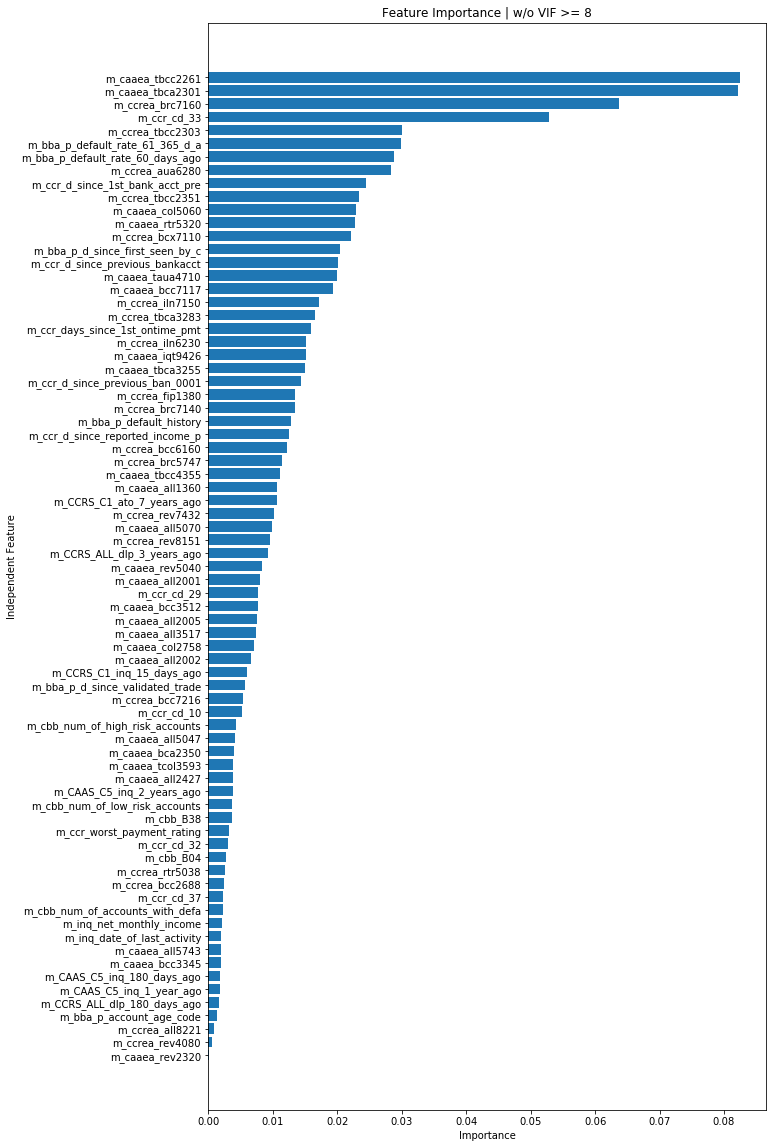

In [20]:
# get & display top 50 important features for VIF >= 8 also get it's random forest regressor
X8_top_feats, X8_top_feats_rfr = display_important_features(X8, X8_train, y8_train, dataset="w/o VIF >= 8")

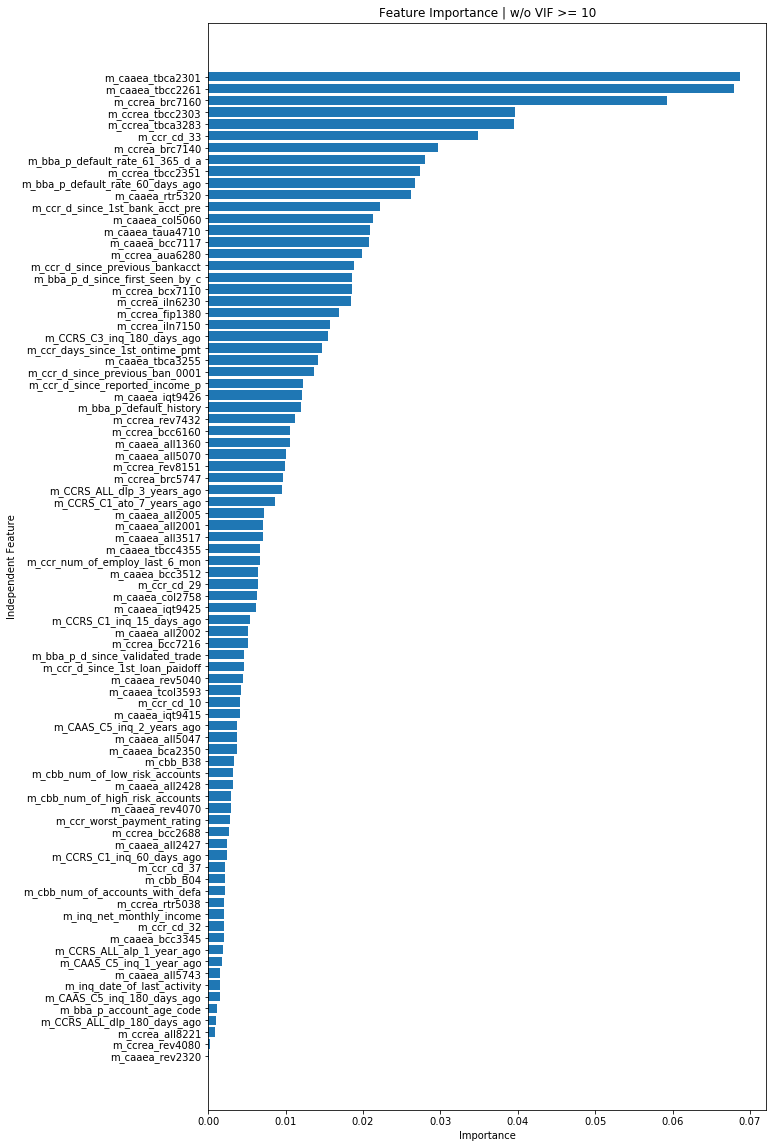

In [21]:
# display top important features for VIF >= 10 also get its random forest regressor
X10_top_feats, X10_top_feats_rfr = display_important_features(X10, X10_train, y10_train, dataset="w/o VIF >= 10")